In [3]:
from numpy.random import seed
seed(101)
import tensorflow
tensorflow.random.set_seed(101)

import pandas as pd
import numpy as np

from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_accuracy, top_k_categorical_accuracy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

import os

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
import shutil
import matplotlib.pyplot as plt
%matplotlib inline

In [41]:
os.listdir('C:/Windows/System32/Data Analytics/input')

['HAM10000_images_part_1',
 'HAM10000_images_part_2',
 'HAM10000_metadata.csv',
 'hmnist_28_28_L.csv',
 'hmnist_28_28_RGB.csv',
 'hmnist_8_8_L.csv',
 'hmnist_8_8_RGB.csv']

In [4]:
# Create a new directory

base_dir = 'base_dir'
os.mkdir(base_dir)

#creating a path to'base_dir'

#train_dir
train_dir = os.path.join(base_dir, 'train_dir')
os.mkdir(train_dir)

#val_dir
val_dir = os.path.join(base_dir, 'val_dir')
os.mkdir(val_dir)

#creating seperate folders for each class

#inside Train_dir
nv = os.path.join(train_dir, 'nv')
os.mkdir(nv)
mel = os.path.join(train_dir, 'mel')
os.mkdir(mel)
bkl = os.path.join(train_dir, 'bkl')
os.mkdir(bkl)
bcc = os.path.join(train_dir, 'bcc')
os.mkdir(bcc)
akiec = os.path.join(train_dir, 'akiec')
os.mkdir(akiec)
vasc = os.path.join(train_dir, 'vasc')
os.mkdir(vasc)
df = os.path.join(train_dir, 'df')
os.mkdir(df)

#inside val_dir
nv = os.path.join(val_dir, 'nv')
os.mkdir(nv)
mel = os.path.join(val_dir, 'mel')
os.mkdir(mel)
bkl = os.path.join(val_dir, 'bkl')
os.mkdir(bkl)
bcc = os.path.join(val_dir, 'bcc')
os.mkdir(bcc)
akiec = os.path.join(val_dir, 'akiec')
os.mkdir(akiec)
vasc = os.path.join(val_dir, 'vasc')
os.mkdir(vasc)
df = os.path.join(val_dir, 'df')
os.mkdir(df)

In [5]:
df_data = pd.read_csv('C:/Windows/System32/Data Analytics/input/HAM10000_metadata.csv')
df_data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [6]:
# this will tell us how many images are associated with each lesion_id
df = df_data.groupby('lesion_id').count()

# now we filter out lesion_id's that have only one image associated with it
df = df[df['image_id'] == 1]

df.reset_index(inplace=True)

df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000001,1,1,1,1,1,1
1,HAM_0000003,1,1,1,1,1,1
2,HAM_0000004,1,1,1,1,1,1
3,HAM_0000007,1,1,1,1,1,1
4,HAM_0000008,1,1,1,1,1,1


In [7]:
# here we identify lesion_id's that have duplicate images and those that have only
# one image.

def identify_duplicates(x):

    unique_list = list(df['lesion_id'])

    if x in unique_list:
        return 'no_duplicates'
    else:
        return 'has_duplicates'

# create a new colum that is a copy of the lesion_id column
df_data['duplicates'] = df_data['lesion_id']
# apply the function to this new column
df_data['duplicates'] = df_data['duplicates'].apply(identify_duplicates)

df_data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,duplicates
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,has_duplicates
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,has_duplicates
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,has_duplicates
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,has_duplicates
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,has_duplicates


In [9]:
df_data['duplicates'].value_counts()

duplicates
no_duplicates     5514
has_duplicates    4501
Name: count, dtype: int64

In [8]:
# now we filter out images that don't have duplicates
df = df_data[df_data['duplicates'] == 'no_duplicates']

df.shape

(5514, 8)

In [9]:
# now we create a val set using df because we are sure that none of these images
# have augmented duplicates in the train set
y = df['dx']

_, df_val = train_test_split(df, test_size=0.17, random_state=101, stratify=y)

df_val.shape

(938, 8)

In [12]:
df_val['dx'].value_counts()

dx
nv       751
bkl       75
mel       39
bcc       30
akiec     26
vasc      11
df         6
Name: count, dtype: int64

In [10]:
# This set will be df_data excluding all rows that are in the val set

# This function identifies if an image is part of the train
# or val set.
def identify_val_rows(x):
    # create a list of all the lesion_id's in the val set
    val_list = list(df_val['image_id'])

    if str(x) in val_list:
        return 'val'
    else:
        return 'train'

# identify train and val rows

# create a new colum that is a copy of the image_id column
df_data['train_or_val'] = df_data['image_id']
# apply the function to this new column
df_data['train_or_val'] = df_data['train_or_val'].apply(identify_val_rows)

# filter out train rows
df_train = df_data[df_data['train_or_val'] == 'train']


print(len(df_train))
print(len(df_val))

9077
938


In [11]:
df_val['dx'].value_counts()

dx
nv       751
bkl       75
mel       39
bcc       30
akiec     26
vasc      11
df         6
Name: count, dtype: int64

In [12]:
# Set the image_id as the index in df_data
df_data.set_index('image_id', inplace=True)

In [13]:
# Get a list of images in each of the two folders
folder_1 = os.listdir('C:/Windows/System32/Data Analytics/input/HAM10000_images_part_1')
folder_2 = os.listdir('C:/Windows/System32/Data Analytics/input/HAM10000_images_part_2')

# Get a list of train and val images
train_list = list(df_train['image_id'])
val_list = list(df_val['image_id'])

train_dir = 'C:/Windows/System32/Data Analytics/base_dir/train_dir'

# Transfer the train images

for image in train_list:

    fname = image + '.jpg'
    label = df_data.loc[image,'dx']

    if fname in folder_1:
        # source path to image
        src = os.path.join('C:/Windows/System32/Data Analytics/input/HAM10000_images_part_1', fname)
        # destination path to image
        dst = os.path.join(train_dir, label, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)

    if fname in folder_2:
        # source path to image
        src = os.path.join('C:/Windows/System32/Data Analytics/input/HAM10000_images_part_2', fname)
        # destination path to image
        dst = os.path.join(train_dir, label, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)

val_dir = 'C:/Windows/System32/Data Analytics/base_dir/val_dir'
# Transfer the val images

for image in val_list:

    fname = image + '.jpg'
    label = df_data.loc[image,'dx']

    if fname in folder_1:
        # source path to image
        src = os.path.join('C:/Windows/System32/Data Analytics/input/HAM10000_images_part_1', fname)
        # destination path to image
        dst = os.path.join(val_dir, label, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)

    if fname in folder_2:
        # source path to image
        src = os.path.join('C:/Windows/System32/Data Analytics/input/HAM10000_images_part_2', fname)
        # destination path to image
        dst = os.path.join(val_dir, label, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)

In [44]:
import tempfile
import logging
import os
import shutil
from tensorflow.keras.preprocessing.image import ImageDataGenerator

logger = logging.getLogger(__name__)
logging.basicConfig(level=logging.INFO)

class_list = ['mel', 'bkl', 'bcc', 'akiec', 'vasc', 'df']
num_aug_images_wanted = 6000

def augment_class(class_name, base_dir, save_dir):
    """
    Augments a class of images and saves them to a specific directory.

    Args:
        class_name (str): Name of the class to augment.
        base_dir (str): Path to the directory containing original images.
        save_dir (str): Path to the directory for saving augmented images.

    Returns:
        None
    """
    with tempfile.TemporaryDirectory() as temp_dir:
        img_dir = os.path.join(temp_dir, 'img_dir')
        os.makedirs(img_dir, exist_ok=True)

        try:
            img_list = os.listdir(os.path.join(base_dir, class_name))
            for fname in img_list:
                src = os.path.join(base_dir, class_name, fname)
                dst = os.path.join(img_dir, fname)
                shutil.copyfile(src, dst)

            datagen = ImageDataGenerator(
                rotation_range=180,
                width_shift_range=0.1,
                height_shift_range=0.1,
                zoom_range=0.1,
                horizontal_flip=True,
                vertical_flip=True,
                fill_mode='nearest'
            )
            aug_datagen = datagen.flow_from_directory(
                temp_dir,
                save_to_dir=save_dir,
                save_format='jpg',
                target_size=(224, 224),
                batch_size=32,
                class_mode=None  # Since we only need the augmented images, class_mode is set to None
            )

            num_batches = num_aug_images_wanted // 32  # Calculate the number of batches needed

            for i in range(num_batches):
                next(aug_datagen)

        except FileNotFoundError as e:
            logger.error(f"Error copying files for class {class_name}: {e}")

if __name__ == '__main__':
    base_dir = 'C:/Windows/System32/Data Analytics/base_dir/train_dir'
    save_dir = 'C:/Windows/System32/Data Analytics/base_dir/augmented_images'
    os.makedirs(save_dir, exist_ok=True)
    for item in class_list:
        class_save_dir = os.path.join(save_dir, item)
        os.makedirs(class_save_dir, exist_ok=True)
        augment_class(item, base_dir, class_save_dir)


Found 1074 images belonging to 1 classes.
Found 1024 images belonging to 1 classes.
Found 484 images belonging to 1 classes.
Found 301 images belonging to 1 classes.
Found 131 images belonging to 1 classes.
Found 109 images belonging to 1 classes.


In [56]:
# Check how many train images we now have in each folder.
# This is the original images plus the augmented images.

print(len(os.listdir('C:/Windows/System32/Data Analytics/base_dir/train_dir/nv')))
print(len(os.listdir('C:/Windows/System32/Data Analytics/base_dir/train_dir/mel')))
print(len(os.listdir('C:/Windows/System32/Data Analytics/base_dir/train_dir/bkl')))
print(len(os.listdir('C:/Windows/System32/Data Analytics/base_dir/train_dir/bcc')))
print(len(os.listdir('C:/Windows/System32/Data Analytics/base_dir/train_dir/akiec')))
print(len(os.listdir('C:/Windows/System32/Data Analytics/base_dir/train_dir/vasc')))
print(len(os.listdir('C:/Windows/System32/Data Analytics/base_dir/train_dir/df')))

5954
1074
1024
484
301
131
109


In [57]:
print(len(os.listdir('C:/Windows/System32/Data Analytics/base_dir/val_dir/nv')))
print(len(os.listdir('C:/Windows/System32/Data Analytics/base_dir/val_dir/mel')))
print(len(os.listdir('C:/Windows/System32/Data Analytics/base_dir/val_dir/bkl')))
print(len(os.listdir('C:/Windows/System32/Data Analytics/base_dir/val_dir/bcc')))
print(len(os.listdir('C:/Windows/System32/Data Analytics/base_dir/val_dir/akiec')))
print(len(os.listdir('C:/Windows/System32/Data Analytics/base_dir/val_dir/vasc')))
print(len(os.listdir('C:/Windows/System32/Data Analytics/base_dir/val_dir/df')))

751
39
75
30
26
11
6


In [14]:
train_path = 'C:/Windows/System32/Data Analytics/base_dir/train_dir'
valid_path = 'C:/Windows/System32/Data Analytics/base_dir/val_dir'

num_train_samples = len(df_train)
num_val_samples = len(df_val)
train_batch_size = 64
val_batch_size = 16
image_size = 224

train_steps = int(np.ceil(num_train_samples / train_batch_size))
val_steps = int(np.ceil(num_val_samples / val_batch_size))

In [17]:
print(val_steps)

59


In [15]:
datagen = ImageDataGenerator(
    preprocessing_function= \
    tensorflow.keras.applications.mobilenet.preprocess_input)

train_batches = datagen.flow_from_directory(train_path,
                                            target_size=(image_size,image_size),
                                            batch_size=train_batch_size)

valid_batches = datagen.flow_from_directory(valid_path,
                                            target_size=(image_size,image_size),
                                            batch_size=val_batch_size, shuffle = False)

# Note: shuffle=False causes the test dataset to not be shuffled
test_batches = datagen.flow_from_directory(valid_path,
                                            target_size=(image_size,image_size),
                                            batch_size=1,
                                            shuffle=False)


Found 9077 images belonging to 7 classes.
Found 938 images belonging to 7 classes.
Found 938 images belonging to 7 classes.


In [19]:
# create a copy of a mobilenet model

mobile = tensorflow.keras.applications.mobilenet.MobileNet()

In [20]:
mobile.summary()

Model: "mobilenet_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1 (Conv2D)                       │ (None, 112, 112, 32)        │             864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_bn (BatchNormalization)        │ (None, 112, 112, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_relu (ReLU)                    │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1 (DepthwiseConv2D)          │ (None, 112, 112, 32)        │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_bn (BatchNormalization)    │ (None, 112, 112, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_relu (ReLU)                │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1 (Conv2D)                   │ (None, 112, 112, 64)        │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_bn (BatchNormalization)    │ (None, 112, 112, 64)        │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_relu (ReLU)                │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pad_2 (ZeroPadding2D)           │ (None, 113, 113, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2 (DepthwiseConv2D)          │ (None, 56, 56, 64)          │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_bn (BatchNormalization)    │ (None, 56, 56, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_relu (ReLU)                │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2 (Conv2D)                   │ (None, 56, 56, 128)         │           8,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_bn (BatchNormalization)    │ (None, 56, 56, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_relu (ReLU)                │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3 (DepthwiseConv2D)          │ (None, 56, 56, 128)         │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_bn (BatchNormalization)    │ (None, 56, 56, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_relu (ReLU)                │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_3 (Conv2D)                   │ (None, 56, 56, 128)         │          16,384 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 4,253,864 (16.23 MB)

 Trainable params: 4,231,976 (16.14 MB)

 Non-trainable params: 21,888 (85.50 KB)

In [21]:
type(mobile.layers)

list

In [22]:
# How many layers does MobileNet have?
len(mobile.layers)

91

In [23]:
# CREATE THE MODEL ARCHITECTURE
from tensorflow.keras.layers import Dropout, Dense, Flatten
# Exclude the last 5 layers of the above model.
# This will include all layers up to and including global_average_pooling2d_1
x = mobile.layers[-6].output

x = Flatten()(x)
predictions = Dense(7, activation='softmax')(x)

model = Model(inputs=mobile.input, outputs=predictions)

# Create a new dense layer for predictions
# 7 corresponds to the number of classes
x = Dropout(0.25)(x)
predictions = Dense(7, activation='softmax')(x)

# inputs=mobile.input selects the input layer, outputs=predictions refers to the
# dense layer we created above.

model = Model(inputs=mobile.input, outputs=predictions)

In [24]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1 (Conv2D)                       │ (None, 112, 112, 32)        │             864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_bn (BatchNormalization)        │ (None, 112, 112, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_relu (ReLU)                    │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1 (DepthwiseConv2D)          │ (None, 112, 112, 32)        │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_bn (BatchNormalization)    │ (None, 112, 112, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_relu (ReLU)                │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1 (Conv2D)                   │ (None, 112, 112, 64)        │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_bn (BatchNormalization)    │ (None, 112, 112, 64)        │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_relu (ReLU)                │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pad_2 (ZeroPadding2D)           │ (None, 113, 113, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2 (DepthwiseConv2D)          │ (None, 56, 56, 64)          │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_bn (BatchNormalization)    │ (None, 56, 56, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_relu (ReLU)                │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2 (Conv2D)                   │ (None, 56, 56, 128)         │           8,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_bn (BatchNormalization)    │ (None, 56, 56, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_relu (ReLU)                │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3 (DepthwiseConv2D)          │ (None, 56, 56, 128)         │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_bn (BatchNormalization)    │ (None, 56, 56, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_relu (ReLU)                │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_3 (Conv2D)                   │ (None, 56, 56, 128)         │          16,384 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 3,580,103 (13.66 MB)

 Trainable params: 3,558,215 (13.57 MB)

 Non-trainable params: 21,888 (85.50 KB)

In [68]:
# We need to choose how many layers we actually want to be trained.

# Here we are freezing the weights of all layers except the
# last 23 layers in the new model.
# The last 23 layers of the model will be trained.

for layer in model.layers[:-23]:
    layer.trainable = False

In [9]:
# Define Top2 and Top3 Accuracy

from tensorflow.keras.metrics import categorical_accuracy, top_k_categorical_accuracy


def top_3_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

def top_2_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=2)

In [42]:
model.compile(Adam(learning_rate=0.01), loss='categorical_crossentropy', 
              metrics=[categorical_accuracy, top_2_accuracy, top_3_accuracy])

In [25]:
# Get the labels that are associated with each index
print(valid_batches.class_indices)

{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}


In [9]:
# Add weights to try to make the model more sensitive to melanoma

class_weights={
    0: 1, # akiec
    1: 1, # bcc
    2: 1, # bkl
    3: 1, # df
    4: 3, # mel # Try to make the model more sensitive to Melanoma.
    5: 1, # nv
    6: 1, # vasc
}

In [ ]:
filepath = "model.keras"
checkpoint = ModelCheckpoint(filepath, monitor='val_top_3_accuracy', verbose=1, 
                             save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_top_3_accuracy', factor=0.5, patience=2, 
                                   verbose=1, mode='max', min_lr=0.00001)
                              
                              
callbacks_list = [checkpoint, reduce_lr]

history = model.fit(train_batches, steps_per_epoch=train_steps,
                        class_weight=class_weights,
                        validation_data=valid_batches,
                        validation_steps=val_steps,
                        epochs=10, verbose=1, 
                        callbacks=callbacks_list)

Epoch 1/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.5957 - loss: 2.5783 - top_2_accuracy: 0.7973 - top_3_accuracy: 0.9061
Epoch 1: val_top_3_accuracy improved from -inf to 0.93923, saving model to model.keras
142/142 ━━━━━━━━━━━━━━━━━━━━ 389s 3s/step - categorical_accuracy: 0.5957 - loss: 2.5805 - top_2_accuracy: 0.7973 - top_3_accuracy: 0.9060 - val_categorical_accuracy: 0.3571 - val_loss: 41.6137 - val_top_2_accuracy: 0.8422 - val_top_3_accuracy: 0.9392 - learning_rate: 0.0100
Epoch 2/10
138/142 ━━━━━━━━━━━━━━━━━━━━ 13s 3s/step - categorical_accuracy: 0.5991 - loss: 1.6152 - top_2_accuracy: 0.7810 - top_3_accuracy: 0.8824

In [76]:
# Here the the last epoch will be used.

val_loss, val_cat_acc, val_top_2_acc, val_top_3_acc = \
model.evaluate(test_batches, 
                        steps=len(df_val))

print('val_loss:', val_loss)
print('val_cat_acc:', val_cat_acc)
print('val_top_2_acc:', val_top_2_acc)
print('val_top_3_acc:', val_top_3_acc)

938/938 ━━━━━━━━━━━━━━━━━━━━ 19s 20ms/step - categorical_accuracy: 0.5141 - loss: 5.9655 - top_2_accuracy: 0.5782 - top_3_accuracy: 0.7899
val_loss: 2.2192516326904297
val_cat_acc: 0.8038379549980164
val_top_2_acc: 0.8496801853179932
val_top_3_acc: 0.9232409596443176


In [77]:
# Here the best epoch will be used.

model.load_weights('model.keras')

val_loss, val_cat_acc, val_top_2_acc, val_top_3_acc = \
model.evaluate(test_batches, 
                        steps=len(df_val))

print('val_loss:', val_loss)
print('val_cat_acc:', val_cat_acc)
print('val_top_2_acc:', val_top_2_acc)
print('val_top_3_acc:', val_top_3_acc)

938/938 ━━━━━━━━━━━━━━━━━━━━ 18s 20ms/step - categorical_accuracy: 0.5705 - loss: 2.2358 - top_2_accuracy: 0.6442 - top_3_accuracy: 0.8086
val_loss: 0.8979320526123047
val_cat_acc: 0.8113006353378296
val_top_2_acc: 0.8667377233505249
val_top_3_acc: 0.9402984976768494


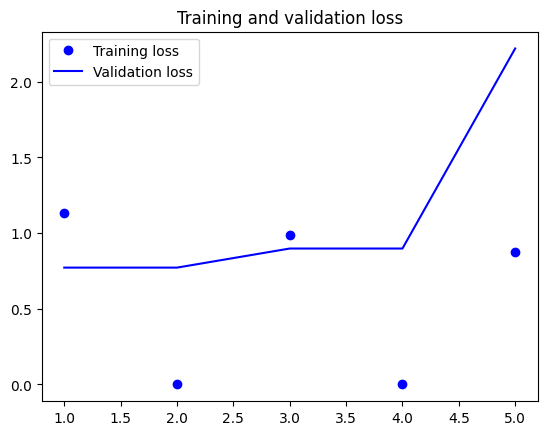

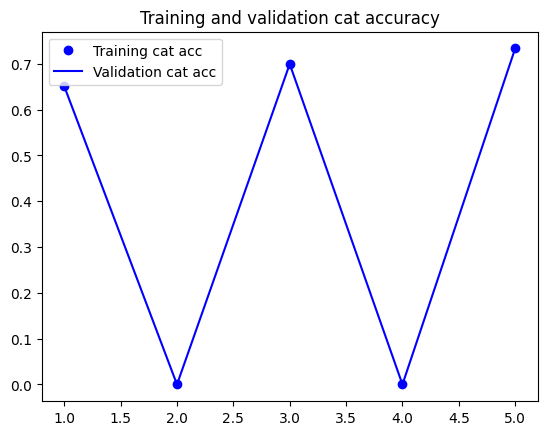

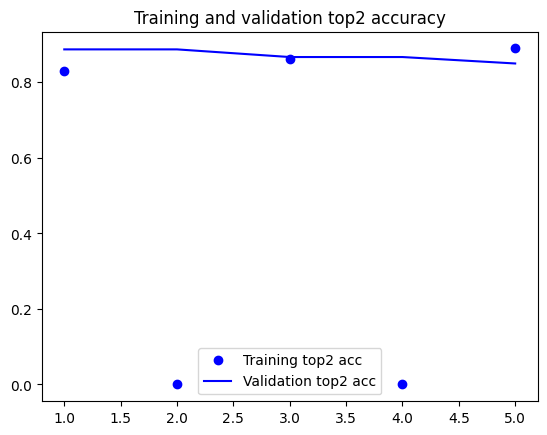

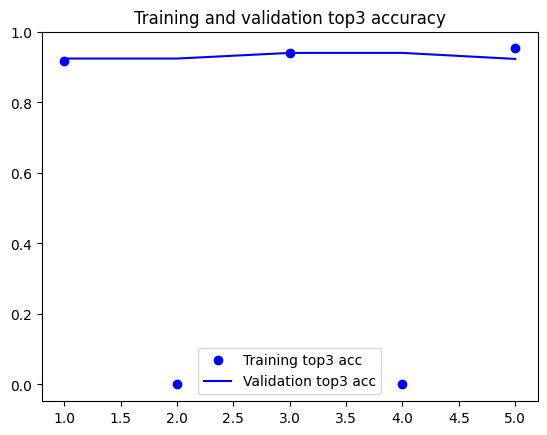

In [78]:
# display the loss and accuracy curves

import matplotlib.pyplot as plt

acc = history.history['categorical_accuracy']
val_acc = history.history['categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
train_top2_acc = history.history['top_2_accuracy']
val_top2_acc = history.history['val_top_2_accuracy']
train_top3_acc = history.history['top_3_accuracy']
val_top3_acc = history.history['val_top_3_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()

plt.plot(epochs, acc, 'bo', label='Training cat acc')
plt.plot(epochs, val_acc, 'b', label='Validation cat acc')
plt.title('Training and validation cat accuracy')
plt.legend()
plt.figure()


plt.plot(epochs, train_top2_acc, 'bo', label='Training top2 acc')
plt.plot(epochs, val_top2_acc, 'b', label='Validation top2 acc')
plt.title('Training and validation top2 accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, train_top3_acc, 'bo', label='Training top3 acc')
plt.plot(epochs, val_top3_acc, 'b', label='Validation top3 acc')
plt.title('Training and validation top3 accuracy')
plt.legend()


plt.show()

In [18]:
import tensorflow as tf
# Define the custom metric functions
def top_2_accuracy(y_true, y_pred):
    return tf.keras.metrics.top_k_categorical_accuracy(y_true, y_pred, k=2)

def top_3_accuracy(y_true, y_pred): 
    return tf.keras.metrics.top_k_categorical_accuracy(y_true, y_pred, k=3)

# Register the custom metric functions
tf.keras.utils.get_custom_objects()['top_2_accuracy'] = top_2_accuracy
tf.keras.utils.get_custom_objects()['top_3_accuracy'] = top_3_accuracy

# Load the model in native Keras format
model = tf.keras.models.load_model(
    'C:/Windows/System32/Data Analytics/model.keras',
    custom_objects={'top_2_accuracy': top_2_accuracy, 'top_3_accuracy': top_3_accuracy}
)

In [31]:
# Convert model architecture to JSON format
model_json = model.to_json()
with open('C:/Windows/System32/Data Analytics/model.json', 'w') as json_file:
    json_file.write(model_json)

In [32]:
# Save the model weights to an HDF5 file
model.save_weights('C:/Windows/System32/Data Analytics/model.weights.h5')

In [33]:
from tensorflow.keras.models import model_from_json

# Load model architecture from JSON file
with open('C:/Windows/System32/Data Analytics/model.json', 'r') as json_file:
    model_json = json_file.read()

model = model_from_json(model_json)

# Load model weights
model.load_weights('C:/Windows/System32/Data Analytics/model.weights.h5')

In [27]:
# Get the labels of the test images.

test_labels = test_batches.classes

In [28]:
# We need these to plot the confusion matrix.
test_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3,
       3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,

In [29]:
# Print the label associated with each class
test_batches.class_indices

{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}

In [31]:
# make a prediction
predictions = model.predict(test_batches, steps=len(df_val), verbose=1)

C:\Users\marsh\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


938/938 ━━━━━━━━━━━━━━━━━━━━ 16s 16ms/step


In [32]:
predictions.shape

(938, 7)

In [33]:
# Source: Scikit Learn website
# http://scikit-learn.org/stable/auto_examples/
# model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-
# selection-plot-confusion-matrix-py


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [34]:
test_labels.shape

(938,)

In [35]:
# argmax returns the index of the max value in a row
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))

In [36]:
test_batches.class_indices

{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}

Confusion matrix, without normalization
[[  1  13   4   0   6   2   0]
 [  0  10   8   0   9   2   1]
 [  2  25  20   0  20   7   1]
 [  0   1   2   0   2   0   1]
 [  2  19   9   0   5   4   0]
 [ 10 343 246   4  99  33  16]
 [  0   4   3   0   1   1   2]]


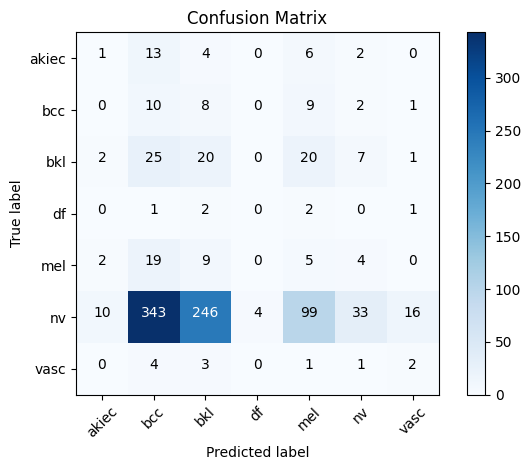

In [37]:
# Define the labels of the class indices. These need to match the 
# order shown above.
cm_plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'mel','nv', 'vasc']

plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

In [38]:
# Get the index of the class with the highest probability score
y_pred = np.argmax(predictions, axis=1)

# Get the labels of the test images.
y_true = test_batches.classes

In [39]:
from sklearn.metrics import classification_report

# Generate a classification report
report = classification_report(y_true, y_pred, target_names=cm_plot_labels)

print(report)

              precision    recall  f1-score   support

       akiec       0.07      0.04      0.05        26
         bcc       0.02      0.33      0.04        30
         bkl       0.07      0.27      0.11        75
          df       0.00      0.00      0.00         6
         mel       0.04      0.13      0.06        39
          nv       0.67      0.04      0.08       751
        vasc       0.10      0.18      0.12        11

    accuracy                           0.08       938
   macro avg       0.14      0.14      0.07       938
weighted avg       0.55      0.08      0.08       938



1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 727ms/step
Predicted class: vasc
Class probabilities: [[0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 1.000000e+00
  1.836085e-30 0.000000e+00]]


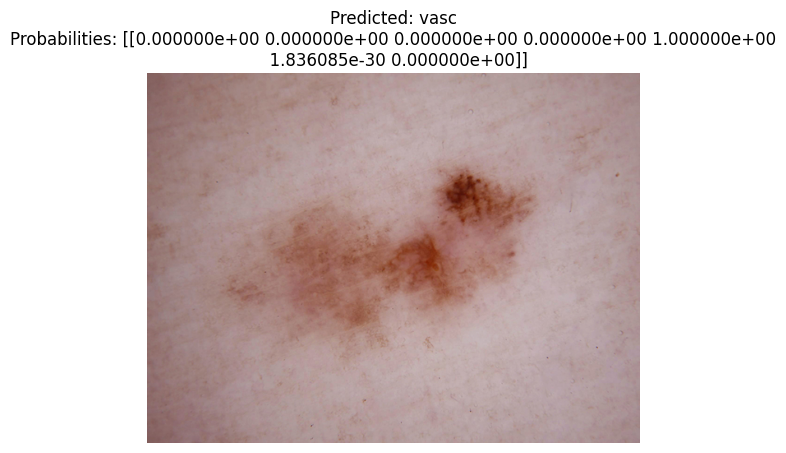

In [22]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Define custom metrics
def top_2_accuracy(y_true, y_pred):
    return tf.keras.metrics.top_k_categorical_accuracy(y_true, y_pred, k=2)

def top_3_accuracy(y_true, y_pred):
    return tf.keras.metrics.top_k_categorical_accuracy(y_true, y_pred, k=3)

# Load the model
model = load_model('model.keras', custom_objects={'top_2_accuracy': top_2_accuracy, 'top_3_accuracy': top_3_accuracy})

def display_image_with_prediction(image_path, predicted_class_label, class_probabilities):
    img = image.load_img(image_path)
    plt.imshow(img)
    plt.title(f'Predicted: {predicted_class_label}\nProbabilities: {class_probabilities}')
    plt.axis('off')
    plt.show()
    
# Define predict function
def predict(input_data, model, class_labels=None):
    
    input_data = np.array(input_data)
    predictions = model.predict(input_data)
    
    if class_labels is not None:
        predicted_class_index = np.argmax(predictions, axis=1)[0]
        predicted_class_label = class_labels[predicted_class_index]
        return predicted_class_label, predictions
    return predictions

# Load and preprocess image
def load_and_preprocess_image(image_path, target_size):
    img = image.load_img(image_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array /= 255.0  # Normalize to [0, 1] range
    return img_array

# Example usage
image_path = 'C:/Windows/System32/Data Analytics/ISIC_0027900.jpg'
input_data = load_and_preprocess_image(image_path, target_size=(224, 224))  # Adjust target_size as needed

class_labels = ['mel', 'bkl', 'bcc', 'akiec', 'vasc', 'df']

predicted_class_label, predictions = predict(input_data, model, class_labels=class_labels)

print("Predicted class:", predicted_class_label)
print("Class probabilities:", predictions)
display_image_with_prediction(image_path, predicted_class_label, predictions)
